In [1]:
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from src.files.fasta import FASTAFile
from Bio import Phylo
from itertools import product, combinations
from utils import *
from src.coevolution import get_scores
from scipy.stats import mannwhitneyu
from src.files.itol import *
import io
from src.tree import *  

%load_ext autoreload 
%autoreload 2

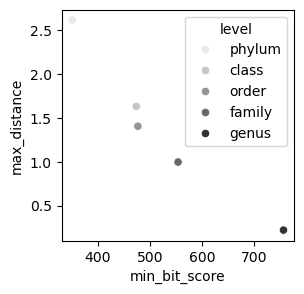

In [ ]:
# It is clear that there are imbalances at each phylogenetic level, which means I need to be careful about normalization.
# In order to pick a good level for normalization, I am going to look at how sequence identity varies for aRF1 between orders.

# Should be duplicates in the alignment DataFrame. 


if not os.path.exists('./data/sandbox-3_figure-2.csv'):

    pwa_df = pd.read_csv('../data/arf1_cleaned_align.tsv', usecols=[0, 1, 2, 3, 4], sep='\t', names=['query_id', 'target_id', 'e_value', 'percent_identity', 'bit_score'])
    pwa_df = pwa_df[pwa_df.query_id != pwa_df.target_id].copy() # Remove self-alignments. 
    percent_identity_map = pwa_df.set_index(['query_id', 'target_id'])['percent_identity'].to_dict() # Map query and target IDs to percent identity.
    bit_score_map = pwa_df.set_index(['query_id', 'target_id'])['bit_score'].to_dict() # Map query and target IDs to percent identity.

    ref = arf1_df[arf1_df.category == 'pyl+'].iloc[0]
    tree = gtdb_load_ar53_tree()

    figure_df = list()
    for level in ['phylum', 'class', 'order', 'family', 'genus']:
        print(f'Computing distances for level {level}.')
        query_df = arf1_df[arf1_df[level] == ref[level]]# .sample(min(sample_size, (arf1_df[level] == ref[level]).sum()))
        distances = tree_get_distances(query_df, tree, max_distance=None).distance.values
        percent_identities = np.array([percent_identity_map.get(pair, np.nan) for pair in combinations(query_df.index, 2)])
        percent_identities = percent_identities[~np.isnan(percent_identities)].copy()
        bit_scores = np.array([bit_score_map.get(pair, np.nan) for pair in combinations(query_df.index, 2)])
        bit_scores = bit_scores[~np.isnan(bit_scores)].copy()

        row = {'level':level}
        row['min_distance'], row['max_distance'], row['mean_distance'] = distances.min(), distances.max(), distances.mean()
        row['min_percent_identity'], row['max_percent_identity'], row['mean_percent_identity'] = percent_identities.min(), percent_identities.max(), percent_identities.mean()
        row['min_bit_score'], row['max_bit_score'], row['mean_bit_score'] = bit_scores.min(), bit_scores.max(), bit_scores.mean()
        row['reference_taxon'] = ref[level]
        figure_df.append(row)

    figure_df = pd.DataFrame(figure_df)
    figure_df = figure_df.sort_values('min_distance')
    figure_df.to_csv('./data/sandbox-3_figure-2.csv')
else:
    figure_df = pd.read_csv('./data/sandbox-3_figure-2.csv', index_col=0)

fig, ax = plt.subplots(figsize=(3, 3))
# sns.scatterplot(figure_df, x='mean_bit_score', y='mean_distance', hue='level', palette='Grays', ax=ax)
sns.scatterplot(figure_df, x='min_bit_score', y='max_distance', hue='level', palette='Grays', ax=ax)
plt.show()

In [ ]:
# Would be good to have some kind of plot visualizing a correlation between distance (from what?) and 
# where each mutation was acquired. Probably would be helpful to visualize the trees first. 

# Re-load the aRF1 data
arf1_df = load_arf1_dataset(exclude_genome_ids=['GCA_003164755.1'])
msa_df = load_msa('../data/arf1_cleaned.afa', ids=arf1_df.index, conservation_threshold=0.8)

genome_ids = dict()
genome_ids['methanosarcinales'] = arf1_df[arf1_df['order'] == 'Methanosarcinales'].genome_id.values
genome_ids['methanomassiliicoccales'] = arf1_df[arf1_df['order'] == 'Methanomassiliicoccales'].genome_id.values

position = 78 
field = f'position_{position}'

palette = tree_get_palette_discrete(name='tab20c', values=list('ACDEFGHIKLMNPQRSTVWY'))
palette['-'] = black

for order, genome_ids_ in genome_ids.items():
    arf1_df_ = arf1_df[arf1_df.genome_id.isin(genome_ids_)].copy()
    msa_df_ = msa_df.loc[arf1_df_.index].copy()

    if position is not None:
        arf1_df_[field] = msa_df[position]
        styles = {row.species:'bold' for row in arf1_df_[arf1_df_.category != 'pyl-'].itertuples()}
        sizes = {row.species:2 for row in  arf1_df_[arf1_df_.category != 'pyl-'].itertuples()}
        tree_make_annotation_file(arf1_df_.set_index('species'), field=field, palette=palette, path=f'../data/trees/ar53_{order}_{field}_species.txt', styles=styles, sizes=sizes)
    

for order, genome_ids_ in genome_ids.items():

    arf1_df_ = arf1_df[arf1_df.genome_id.isin(genome_ids_)].copy()
    msa_df_ = msa_df.loc[arf1_df_.index].copy()
    
    palette = tree_get_palette_continuous(name='coolwarm', values=arf1_df_.tag_percent)

    styles = {row.species:'bold' for row in arf1_df_[arf1_df_.category != 'pyl-'].itertuples()}
    sizes = {row.species:2 for row in  arf1_df_[arf1_df_.category != 'pyl-'].itertuples()}
    tree_make_annotation_file(arf1_df_.set_index('species'), field='tag_percent', palette=palette, path=f'../data/trees/ar53_{order}_tag_percent_species.txt', styles=styles, sizes=sizes, legend=False)

In [12]:
# Want to create a tree corresponding to the Methanosarcinales analysis, possibly with one representative per genus.
# Honestly maybe do a tree with everything, not just Methanosarcinales. There are 44 classes which pass the filter. 

arf1_df = load_arf1_dataset(exclude_genome_ids=['GCA_003164755.1'])

print('Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories:', (arf1_df.category == 'pyl+').sum())
arf1_df = arf1_df[arf1_df.category != 'pyl+'].copy()
print('Num. potentially-mislabeled Pyl- sequences being discarded:', ((arf1_df.category == 'pyl-') & (arf1_df.tag_percent < 0.05)).sum())
arf1_df = arf1_df[~((arf1_df.category == 'pyl-') & (arf1_df.tag_percent < 0.05))].copy()

min_phylum_size = 10
phylum_counts = arf1_df.phylum.value_counts()
mask = arf1_df.phylum.isin(phylum_counts[phylum_counts >= min_phylum_size].index.values)
print(f'Discarding {(~mask).sum()} sequences from phyla which do not meet the minimum size threshold.')
arf1_df = arf1_df[arf1_df.phylum.isin(phylum_counts[phylum_counts >= min_phylum_size].index.values)].copy()

arf1_df['category'] = arf1_df.category.replace({'pyl+ recoded':'pyl+'})

# Pick one representative per level. 
# level = 'genus' 
# arf1_df = arf1_df.drop_duplicates(level)
# print(f'Num. unique {level}:', len(arf1_df))

level = 'genus' 
arf1_df = arf1_df[arf1_df.order == 'Methanosarcinales'].drop_duplicates(level)
print(f'Num. unique {level} in order Methanosarcinales:', len(arf1_df))

# Subset the GTDB tree to only obtain the sample of genomes. 
tree = gtdb_load_ar53_tree(genome_ids=arf1_df.genome_id.unique())
tree = tree_relabel(tree, label_map=arf1_df.set_index('genome_id')[level].to_dict())
tree_write(tree, f'../data/trees/ar53_methanosarcinales_{level}.tree')

palette = {True:'steelblue', False:'indianred'}
tree_make_annotation_file(arf1_df.set_index('genus'), field='has_pyl', palette=palette, path=f'../data/trees/ar53_methanosarcinales_has_pyl_{level}.txt', legend=False)



Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories: 73
Num. potentially-mislabeled Pyl- sequences being discarded: 11
Discarding 18 sequences from phyla which do not meet the minimum size threshold.
Num. unique genus in order Methanosarcinales: 17
